# Fake News detection - Adilet Gaparov

**Content**:
1. [Importing libraries](#import)
2. [Loading raw data](#load)
3. [Cleaning the data](#clean)
4. [Preprocessing](#preprocessing)
5. [Modeling](#modeling)
6. [Experimentation: word embeddings + Neural Network](#word2vec)


## 1. Importing libraries <a id=import>

In [1]:
# saving the data
import pickle
from joblib import dump, load

# data visualization
import matplotlib.pyplot as plt

# preprocessing
import pandas as pd
import numpy as np
import spacy
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# modeling
#import tensorflow as tf
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV

# fixing random seed
np.random.seed(289)

## 2. Loading raw data <a id=load>

In [9]:
raw_news_train = pd.read_csv('data/fake_or_real_news_training.csv')
raw_news_test = pd.read_csv('data/fake_or_real_news_test.csv')

In [10]:
raw_news_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2321 entries, 0 to 2320
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      2321 non-null   int64 
 1   title   2321 non-null   object
 2   text    2321 non-null   object
dtypes: int64(1), object(2)
memory usage: 54.5+ KB


In [11]:
raw_news_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3999 entries, 0 to 3998
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      3999 non-null   int64 
 1   title   3999 non-null   object
 2   text    3999 non-null   object
 3   label   3999 non-null   object
 4   X1      33 non-null     object
 5   X2      2 non-null      object
dtypes: int64(1), object(5)
memory usage: 187.6+ KB


> We have two columns `X1` and `X2` in `train` set that have some values. Let's check them

In [12]:
X1 = raw_news_train.X1.notnull()
X2 = raw_news_train.X2.notnull()

In [13]:
raw_news_train[X2]

,ID,title,text,label,X1,X2
2184,9,Planned Parenthood’s lobbying effort,pay raises for federal workers,and the future Fed rates,PLANNED PARENTHOOD’S LOBBYING GETS AGGRESSIVE....,REAL
3537,6268,Chart Of The Day: Since 2009—–Recovery For The 5%,Stagnation for the 95%,Chart Of The Day: Since 2009 Recovery For The 5%,Stagnation for the 95%,FAKE


In [14]:
raw_news_train[X1].head()

,ID,title,text,label,X1,X2
192,599,Election Day: No Legal Pot In Ohio,Democrats Lose In The South,Election Day: No Legal Pot In Ohio; Democrats ...,REAL,NaN
308,10194,Who rode it best? Jesse Jackson mounts up to f...,Leonardo DiCaprio to the rescue?,Who rode it best? Jesse Jackson mounts up to f...,FAKE,NaN
382,356,Black Hawk crashes off Florida,human remains found,(CNN) Thick fog forced authorities to suspend ...,REAL,NaN
660,2786,Afghanistan: 19 die in air attacks on hospital,U.S. investigating,(CNN) Aerial bombardments blew apart a Doctors...,REAL,NaN
889,3622,Al Qaeda rep says group directed Paris magazin...,US issues travel warning,A member of Al Qaeda's branch in Yemen said Fr...,REAL,NaN


## 3. Cleaning the data <a id=clean>

Before we proceed with feature engineering, we need to fix those rows, where `X1` and `X2` are not empty. Moreover, let's combine `title` and `text` columns into one column to process together and remove noise. 

> Noise removal function was taken from the following blog post: https://towardsdatascience.com/a-complete-exploratory-data-analysis-and-visualization-for-text-data-29fb1b96fb6a

In [7]:
def retrieve_text_labels(data, dataset_type='train'):
    """Returns list of documents and numerical labels (0 for `FAKE`, 1 for `REAL`)
    
    'data' must contain columns `title`, `text`, `label`. 
    Additional columns `X1`, `X2` are expected to be in the `data`, if dataset_type=`train`
    
    If dataset_type=`train`, returns list of documents and list of numerical labels. 
    If dataset_type=`test`, returns list of documents without labels. 
    
    If dataset_type=`train`, additional columns `X1`, `X2` are expected to be in the `data`.       
    """
    
    def remove_noise(text):
        text = text.str.replace("(<br/>)", "")
        text = text.str.replace('(<a).*(>).*(</a>)', '')
        text = text.str.replace('(&amp)', '')
        text = text.str.replace('(&gt)', '')
        text = text.str.replace('(&lt)', '')
        text = text.str.replace('(\xa0)', ' ')  
        return text
    
    if dataset_type == 'train':
        
        data.loc[:, 'full_text'] = data.title + '. ' + data.text + ' ' + data.label + data.fillna('').X1 + data.fillna('').X2
        data.loc[:, 'full_text'] = remove_noise(data.loc[:, 'full_text'])
        
        # since both 'REAL' and 'FAKE' contain 4 letters, I am taking the last 4 letters to be labels
        train = data.full_text.apply(lambda row: row[:-4]).tolist()
        labels = data.full_text.apply(lambda row: row[-4:]).replace({'FAKE':0, 'REAL':1}).tolist()
        
        return train, labels
    
    else:
        
        data.loc[:, 'full_text'] = data.title + '. ' + data.text
        data.loc[:, 'full_text'] = remove_noise(data.loc[:, 'full_text'])
        
        train = data.full_text.to_list()
        
        return train

In [15]:
news_train, labels = retrieve_text_labels(raw_news_train, 'train')
labels = np.array(labels)

## 4. Preprocessing <a id=preprocessing>

For preprocessing, we are going to use spaCy package and their medium-size pre-trained statistical model for English, because it was trained on web-content (blogs, `news`, comments). Requires separate [installation](https://spacy.io/models/en#en_core_web_md).

In [2]:
nlp = spacy.load("en_core_web_md")

### 4.1 Custom tokenizers using `spaCy` 
We have several hypotheses on how `FAKE` news might be different from `REAL` news:
1. Talking about the same topic (i.e. politics), in `FAKE` news an author might use different words and n-grams (less formal)
2. `FAKE` news might be mostly about politics and crime, hence completely different words and n-grams are used
3. In `FAKE` news an author might use different POS tags, i.e. more adjectives and adverbs, like _incredibly_, _breaking_

To test those hypotheses, we will build two custom tokenizers:
* To get Lemmas of tokens, which are not corresponding to POS tags `SPACE`, `PUNCT`, `X`, `NUM`, `SYM`, `DET`, `PART` 
* To get only POS tags

Since one of our hypotheses is that `FAKE` and `REAL` news use different words, it is important to remove stop-words to better see the difference. 

There are two ways to use custom tokenizers. First, we can create function `lemma_tokenizer` (within which we will use `spaCy` functionalities) and pass it into `tokenizer` keyword argument of sklearn's `CountVectorizer` / `TfidfVectorizer`. However, this is extremely slow process and it is not optimal. The recommended way would be to first tokenize the corpus using `.pipe` method and then apply `CountVectorizer` / `TfidfVectorizer`. 

> `.pipe` method accepts `n_process` keyword argument iff the version of spaCy is at least 2.2.2, otherwise `n_threads` keyword argument should be used

In [16]:
def wrong_token(token):
    """Filters token based on POS-tag"""
    
    wrong_pos = token.pos_ in ['SPACE', 'PUNCT', 'X', 'NUM', 'SYM', 'DET', 'PART', 'INTJ']
    personal_pronoun = (token.lemma_ == '-PRON-')
    
    return personal_pronoun or wrong_pos

> Despite parallelization, still slow process. We saved prepared tokenized train set using *pickle*. See **below**.

In [17]:
def spacy_tokenizer(data, n_process=4, pos=True, stop_words=True):
    """Tokenizes the data using spaCy. If pos=True, returns POS-tags too
    
    Args:
        data: List of documents
        n_process: number of processes to run .pipe method of spaCy object
        pos: if True, returns POS-tags too
        stop_words: if True, remove stop words using NLTK Stopwords list
        
    Returns:
        List: List of lemmatized tokens
    """
    
    if stop_words == True:
        nltk_stopwords = stopwords.words('English')
    
    if spacy.__version__ < '2.2.2':
        data_gen = nlp.pipe(data, n_threads=n_process)
    else:
        data_gen = nlp.pipe(data, n_process=n_process)
        
    data_lemma = []
    
    if pos == True:
        data_pos = []
        
    for token_objects in data_gen:
    
        lemma_tokens = [token.lemma_.lower().strip() for token in token_objects if not wrong_token(token)]
        
        if stop_words == True:
            lemma_tokens = [token for token in lemma_tokens if token not in nltk_stopwords]
        
        data_lemma.append(lemma_tokens)
        
        if pos == True:
            pos_tokens = [token.pos_ for token in token_objects]
            data_pos.append(pos_tokens)
            
    return data_lemma, data_pos

In [ ]:
news_train_lemma, news_train_pos = spacy_tokenizer(news_train)

> Let's save the tokenized train set using *pickle* library for later efficient use

In [ ]:
with open("data/news_train_lemma.pickle", "wb") as f:
    pickle.dump(news_train_lemma, f)
    
with open("data/news_train_pos.pickle", "wb") as f:
    pickle.dump(news_train_pos, f)

> Load the tokenized train set

In [3]:
with open("data/news_train_lemma.pickle", "rb") as f:
    news_train_lemma = pickle.load(f)
    
with open("data/news_train_pos.pickle", "rb") as f:
    news_train_pos = pickle.load(f)

### 4.2 Exploratory Data Analysis
Here we will check several our hypotheses through EDA. Mainly, how `FAKE` and `REAL` news differ in terms of 
1. top unigrams and bigrams
2. frequency of POS tags
3. length of news and number of tokens

In [18]:
def plot_fake_real_diff(tokenized_data, method='tfidf', ngram_range=(1,1), max_features=50, figsize=(20,3), remove_xticks=True):
    """Plots grouped bar plot, showing the difference in tokens used between REAL and FAKE news.
    
    Args:
        tokenized_data: List of tokens
        method: type of vectorizer to use, either
    
    """
    if method == 'tfidf':
        vectorizer = TfidfVectorizer(ngram_range=ngram_range, 
                                     tokenizer=lambda doc: doc, 
                                     preprocessor=lambda doc:doc, 
                                     max_features=max_features)
    elif method == 'count':
        vectorizer = CountVectorizer(ngram_range=ngram_range, 
                                     tokenizer=lambda doc: doc, 
                                     preprocessor=lambda doc:doc, 
                                     max_features=max_features)
    else:
        print("Choose either 'tfidf' for TfidfVectorizer or 'count' for CountVectorizer.")
        return None
        
    document_matrix = vectorizer.fit_transform(tokenized_data)
    document_matrix = pd.DataFrame(document_matrix.A, columns = vectorizer.get_feature_names())
    
    fake = document_matrix.assign(label=labels).groupby('label').sum().iloc[0] / sum(labels == 0)
    real = document_matrix.assign(label=labels).groupby('label').sum().iloc[1] / sum(labels == 1)
    index = document_matrix.assign(label=labels).groupby('label').sum().columns
    
    plt.style.use('seaborn-talk')
    
    pd.DataFrame({'FAKE': fake,'REAL': real}, index=index).plot.bar(rot=90, figsize=figsize)

    if remove_xticks == True:
        plt.xticks([])
        
    plt.show()

#### 4.2.1 Unigrams

By plotting average `TF-IDF` values for the top `50` words by each class (`FAKE`/`REAL`), we can see that there is slight difference between the words used, although the difference is not that clear for unigrams. 

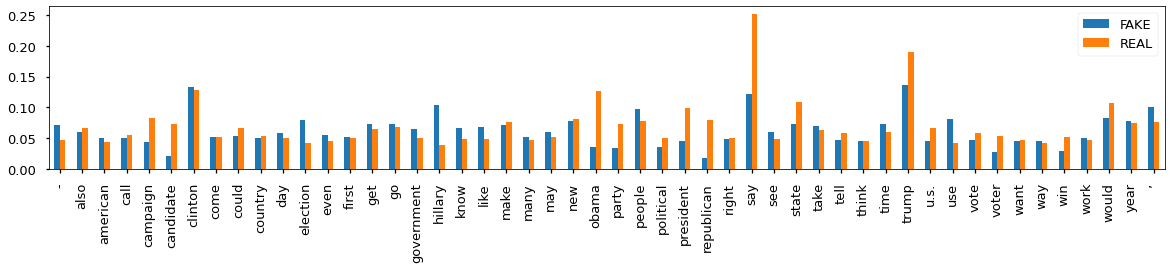

In [19]:
plot_fake_real_diff(news_train_lemma, method='tfidf', ngram_range=(1,1), max_features=50, remove_xticks=False, figsize=(20,3))

#### 4.2.2 Bigrams

Here the difference is quite clear. 

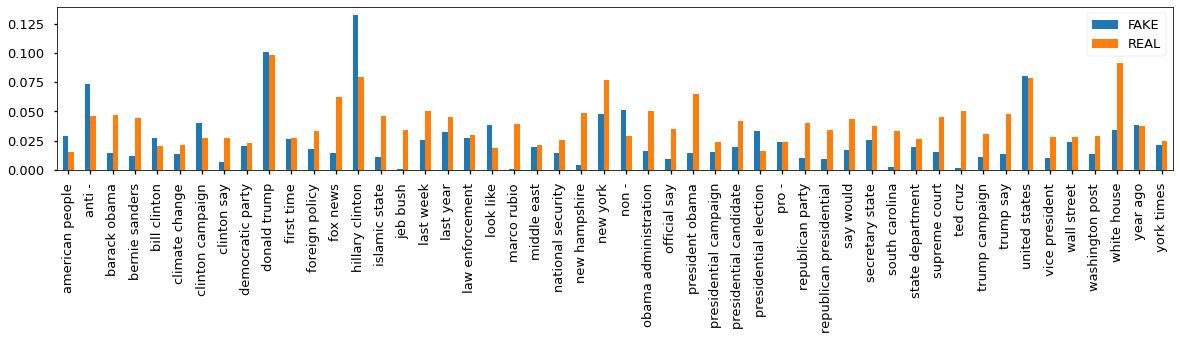

In [20]:
plot_fake_real_diff(news_train_lemma, method='tfidf', ngram_range=(2,2), max_features=50, remove_xticks=False, figsize=(20,3))

#### 4.2.3 POS-tagging frequency

There is difference between `FAKE` and `REAL` news in terms of what POS-tags are used. Interesting enough, `FAKE` news seem to contain more `SYM` (symbols like $, %, §, ©, :), 😝), `X` (other like sfpksdpsxmsa), `INTJ` (interjection like psst, ouch, bravo, hello)

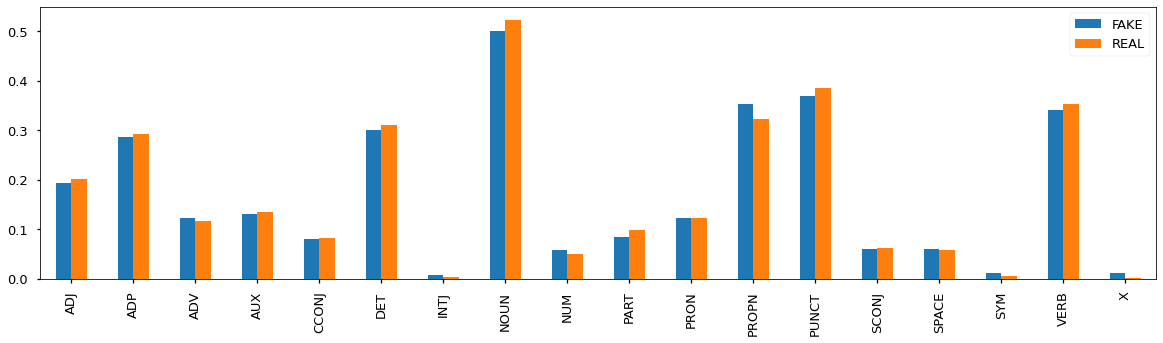

In [21]:
plot_fake_real_diff(news_train_pos, method='tfidf', ngram_range=(1,1), max_features=50, remove_xticks=False, figsize=(20,5))

#### 4.2.4 Length of news and number of tokens

Seems like `FAKE` news are shorter. 

In [22]:
number_of_tokens = [len(lemma_token) for lemma_token in news_train_lemma]
number_of_words = [len(pos_token) for pos_token in news_train_pos]
length_of_news = [len(news) for news in news_train]

pd.DataFrame({'Number of tokens': number_of_tokens, 
              'Number of words': number_of_words, 
              'Length of news': length_of_news, 
              'label': labels}).replace({'label': {0: 'FAKE', 1:'REAL'}}).groupby('label').agg(['mean', 'median'])

Number of tokens        Number of words        Length of news        
                  mean median            mean median           mean  median
label                                                                      
FAKE        377.378704    246      813.106981    519    4185.542943  2694.0
REAL        490.899900    432     1059.981076    937    5359.715139  4763.5

## 5. Modeling <a id=modeling>

The approach for the modeling would be the following:
1. Start with creating a classification model using only TF-IDF matrix based on unigrams. 
2. Create a model using bigrams. 
3. Combine unigrams and bigrams and see if the model improves.
4. Build model based on POS-tagging based document-term matrix and combine POS-tagging doc matrix to see if the model improves.

**Below there are custom functions for modelling to speed up experimentation.**

In [ ]:
def run_experiment(X, y, algorithm, max_features_options=['None'], ngram_range=(1,1), input_type='raw'):
    """Returns the table with cross-validated accuracies for different max_features values and best hyperparameters
    
    Args:
        X: List of documents
        y: labels
        algorithm: algorithm to run, 'NB' for Multinomial Naive Bayes, 'SGD' for SGDClassifier, 'KNN' for K-Nearest Neighbors
        max_features_options: List of values of max_features, used in TfidfVectorizer
        ngram_range: keyword argument of TfidfVectorizer
        input_type: if 'raw', List of document is expected; if 'prepared' the document-term matrix is expected
    
    Returns:
        DataFrame: scores_table, mean and std of the best accuracy scores
        Dict: dictionary of the best hyperparameters, where keys are in the format (algorithm, max_features)
    """
    
    best_params_dict = {}
    scores_table = {'algorithm':[], 'tfidf_max_features':[], 'best_score':[]}
    
    for max_features in max_features_options:
        
        best_score, best_params = train_clf(X=X, 
                                            y=y, 
                                            algorithm=algorithm, 
                                            max_features=max_features, 
                                            ngram_range=ngram_range, 
                                            input_type=input_type)
    
        best_params_dict[(algorithm, max_features)] = best_params
    
        scores_table['algorithm'].append(algorithm)
        scores_table['tfidf_max_features'].append(max_features)
        scores_table['best_score'].append(best_score)
        
    return pd.DataFrame(scores_table), best_params_dict


def train_clf(X, y, algorithm, max_features=1000, ngram_range=(1,1), input_type='raw'):
    """Returns the best accuracy score (mean and std), the best hyperparameters and preprocessed data based on Grid Search
    
    Args:
        X: List of documents
        y: labels
        algorithm: name of the algorithm, one of the following 'NB' (Naive Bayes), 'SGD' (SGDClassifier), 'SVM' (Linear SVM)
        max_features: keyword argument of TfidfVectorizer
        ngram_range: keyword argument of TfidfVectorizer
        input_type: if 'raw', List of document is expected; if 'prepared' the document-term matrix is expected
        
    Returns:
        Float: the mean value of the accuracy of the best model
        Float: the std value of the accuracy of the best model
        Dict: dictionary of the best hyperparameters
    """
    
    if input_type == 'raw':
        X = preprocess_input(X=X, max_features=max_features, ngram_range=ngram_range, output_type='sparse')
    
    if algorithm == 'SGD':
        clf = SGDClassifier(random_state=289, penalty='elasticnet')
        param_grid = {
            'l1_ratio': [0, 0.15, 0.3, 0.45, 0.6],
            'loss': ['hinge', 'modified_huber']
        }
        
    elif algorithm == 'SVM':
        clf = LinearSVC(random_state=289)
        param_grid = {
            'C': [0.1, 0.3, 1, 3, 10, 30],
            'loss': ['hinge', 'squared_hinge']
        }
        
    elif algorithm == 'NB':
        clf = MultinomialNB()
        param_grid = {
            'alpha': [0.1, 0.3, 0.5, 0.7, 1]
        }

    grid_search = GridSearchCV(clf, cv=10, param_grid=param_grid, n_jobs=-1, scoring='accuracy', verbose=10).fit(X, y)
    
    best_estimator = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    
    return best_score, best_params


def preprocess_input(X, max_features, ngram_range, output_type='sparse'):
    """Return TFIDF document-term matrix
    
    Args:
        X: List of documents
        max_features: keyword argument of TfidfVectorizer
        ngram_range: keyword argument of TfidfVectorizer
        output_type: 'sparse' returns sparse matrix, 'df' returns pandas DataFrame
        
    Returns:
        sparse_matrix / DataFrame: preprocessed document-term matrix
    """
    
    tfidf = TfidfVectorizer(ngram_range=ngram_range, 
                            tokenizer=lambda doc: doc, 
                            preprocessor=lambda doc:doc, 
                            max_features=max_features)
    
    X = tfidf.fit_transform(X)

    if output_type == 'df':
        X = pd.DataFrame(X.A, columns=tfidf.get_feature_names())
    
    return X

### 5.1 Unigrams only - top N features

#### 5.1.1 Naive Bayes

* **The best cross-validated score**: `0.907727`
* **TfidfVectorizer's max_features**: `20 000`
* **The best hyperparameters**: `alpha = 0.1`

algorithm	|tfidf_max_features	|best_score
------------|-------------------|---------------
NB	|5000	|0.880720
NB	|10000	|0.900475
NB	|20000	|0.907727
NB	|30000	|0.905476
NB	|40000	|0.901975
NB	|None	|0.897224

In [ ]:
algorithm = 'NB'
max_features_options = [5000, 10000, 20000, 30000, 40000, None]

scores_table, best_params_dict = run_experiment(X=news_train_lemma, 
                                                y=labels, 
                                                algorithm=algorithm, 
                                                max_features_options=max_features_options, 
                                                ngram_range=(1,1), 
                                                input_type='raw')

In [ ]:
# scores_table

In [ ]:
# print(best_params_dict[('NB', 20000)])

#### 5.1.2 Linear SVM

* **The best cross-validated score**: `0.931233`
* **TfidfVectorizer's max_features**: `20 000`
* **The best hyperparameters**: `C = 1, loss = 'squared_hinge'`

algorithm	|tfidf_max_features	|best_score
------------|-------------------|---------------
SVM	|5000	|0.923481
SVM	|10000	|0.926482
SVM	|20000	|0.931233
SVM	|30000	|0.930233
SVM	|40000	|0.930983
SVM	|None	|0.930483

In [ ]:
algorithm = 'SVM'
max_features_options = [5000, 10000, 20000, 30000, 40000, None]

scores_table, best_params_dict = run_experiment(X=news_train_lemma, 
                                                y=labels, 
                                                algorithm=algorithm, 
                                                max_features_options=max_features_options, 
                                                ngram_range=(1,1), 
                                                input_type='raw')

In [ ]:
# scores_table

In [ ]:
# best_params_dict[('SVM', 20000)]

#### 5.1.3 SGDClassifier

* **The best cross-validated score**: `0.927982`
* **TfidfVectorizer's max_features**: `30 000`
* **The best hyperparameters**: `l1_ratio = 0.15, loss = 'hinge'`

algorithm	|tfidf_max_features	|best_score
------------|-------------------|---------------
SGD	|5000	|0.921480
SGD	|10000	|0.924981
SGD	|20000	|0.926732
SGD	|30000	|0.927982
SGD	|40000	|0.927732
SGD	|None	|0.926732

In [ ]:
algorithm = 'SGD'
max_features_options = [5000, 10000, 20000, 30000, 40000, None]

scores_table, best_params_dict = run_experiment(X=news_train_lemma, 
                                                y=labels, 
                                                algorithm=algorithm, 
                                                max_features_options=max_features_options, 
                                                ngram_range=(1,1), 
                                                input_type='raw')

In [ ]:
# scores_table

In [ ]:
# best_params_dict[('SGD', 30000)]

### 5.2 Bigrams only - top N features

#### 5.2.1 Naive Bayes

* **The best cross-validated score**: `0.919480`
* **TfidfVectorizer's max_features**: `40 000`
* **The best hyperparameters**: `alpha = 0.3`


algorithm	|tfidf_max_features	|best_score
------------|-------------------|---------------
NB	|5000	|0.884721
NB	|10000	|0.898475
NB	|20000	|0.910978
NB	|30000	|0.916479
NB	|40000	|0.919480
NB	|None	|0.912728

In [ ]:
algorithm = 'NB'
max_features_options = [5000, 10000, 20000, 30000, 40000, None]

scores_table, best_params_dict = run_experiment(X=news_train_lemma, 
                                                y=labels, 
                                                algorithm=algorithm, 
                                                max_features_options=max_features_options, 
                                                ngram_range=(2,2), 
                                                input_type='raw')

In [ ]:
# scores_table

In [ ]:
# best_params_dict[('NB', 40000)]

#### 5.2.2 Linear SVM

* **The best cross-validated score**: `0.922481`
* **TfidfVectorizer's max_features**: `40 000`
* **The best hyperparameters**: `C = 3, loss = 'squared_hinge'`

algorithm	|tfidf_max_features	|best_score
------------|-------------------|---------------
SVM	|5000	|0.898475
SVM	|10000	|0.912478
SVM	|20000	|0.920480
SVM	|30000	|0.921980
SVM	|40000	|0.922481

In [ ]:
algorithm = 'SVM'
max_features_options = [5000, 10000, 20000, 30000, 40000]

scores_table, best_params_dict = run_experiment(X=news_train_lemma, 
                                                y=labels, 
                                                algorithm=algorithm, 
                                                max_features_options=max_features_options, 
                                                ngram_range=(2,2), 
                                                input_type='raw')

In [ ]:
# scores_table

In [ ]:
# best_params_dict[('SVM', 40000)]

#### 5.2.3 SGDClassifier

* **The best cross-validated score**: `0.923481`
* **TfidfVectorizer's max_features**: `40 000`
* **The best hyperparameters**: `l1_ratio = 0, loss = 'hinge'`

algorithm	|tfidf_max_features	|best_score
------------|-------------------|---------------
SGD	|5000	|0.892473
SGD	|10000	|0.911728
SGD	|20000	|0.915979
SGD	|30000	|0.922731
SGD	|40000	|0.923481
SGD	|None	|0.904476

In [ ]:
algorithm = 'SGD' 
max_features_options = [5000, 10000, 20000, 30000, 40000, None]

scores_table, best_params_dict = run_experiment(X=news_train_lemma, 
                                                y=labels, 
                                                algorithm=algorithm, 
                                                max_features_options=max_features_options, 
                                                ngram_range=(2,2), 
                                                input_type='raw')

In [ ]:
# scores_table

In [ ]:
# best_params_dict[('SGD', 40000)]

### 5.3 Unigrams + Bigrams

#### 5.3.1 Naive Bayes

* **The best cross-validated score**: `0.920730`
* **TfidfVectorizer's max_features**: `60 000`
* **The best hyperparameters**: `alpha = 0.1`


algorithm	|tfidf_max_features	|best_score
------------|-------------------|---------------
NB	|20000	|0.914229
NB	|40000	|0.919980
NB	|60000	|0.920730
NB	|80000	|0.920730

In [ ]:
algorithm = 'NB'
max_features_options = [20000, 40000, 60000, 80000]

scores_table, best_params_dict = run_experiment(X=news_train_lemma, 
                                                y=labels, 
                                                algorithm=algorithm, 
                                                max_features_options=max_features_options, 
                                                ngram_range=(1,2), 
                                                input_type='raw')

In [ ]:
# scores_table

In [ ]:
# best_params_dict[('NB', 80000)]

#### 5.3.2 Linear SVM

* **The best cross-validated score**: `0.934234`
* **TfidfVectorizer's max_features**: `80 000`
* **The best hyperparameters**: `C = 10, loss = 'squared_hinge'`

algorithm	|tfidf_max_features	|best_score
------------|-------------------|---------------
SVM	|20000	|0.929982
SVM	|40000	|0.930733
SVM	|60000	|0.932983
SVM	|80000	|0.934234

In [ ]:
algorithm = 'SVM'
max_features_options = [20000, 40000, 60000, 80000]

scores_table, best_params_dict = run_experiment(X=news_train_lemma, 
                                                y=labels, 
                                                algorithm=algorithm, 
                                                max_features_options=max_features_options, 
                                                ngram_range=(1,2), 
                                                input_type='raw')

In [ ]:
# scores_table

In [ ]:
# best_params_dict[('SVM', 80000)]

#### 5.3.3 SGDClassifier

* **The best cross-validated score**: `0.932483`
* **TfidfVectorizer's max_features**: `80 000`
* **The best hyperparameters**: `l1_ratio = 0, loss = 'hinge'`

algorithm	|tfidf_max_features	|best_score
------------|-------------------|---------------
SGD	|20000	|0.928482
SGD	|40000	|0.931233
SGD	|60000	|0.931733
SGD	|80000	|0.932483

In [ ]:
algorithm = 'SGD'
max_features_options = [20000, 40000, 60000, 80000]

scores_table, best_params_dict = run_experiment(X=news_train_lemma, 
                                                y=labels, 
                                                algorithm=algorithm, 
                                                max_features_options=max_features_options, 
                                                ngram_range=(1,2), 
                                                input_type='raw')

In [ ]:
# scores_table

In [ ]:
# best_params_dict[('SGD', 80000)]

### 5.4 Unigrams + Bigrams + POS-tags

We saw that adding Bigrams features improves all models (**Naive Bayes, SVM, SGDClassifier, KNN**). Let's check if adding POS-tags improves the model too. Before we do that, let's first try to build classification model using just POS-tags and see the performance:

* **Naive Bayes**: `accuracy = 0.880220,  max_features = 20 000`
* **SVM**: `accuracy = 0.876969, max_features = 30 000`
* **SGDClassifier**: `accuracy = 0.873218, max_features = 30 000`
* **KNN**: `accuracy = 0.713178, max_features = 5 000`

In [ ]:
algorithm = 'NB'
max_features_options = [5000, 10000, 20000, 30000]

scores_table, best_params_dict = run_experiment(X=news_train_pos, 
                                                y=labels, 
                                                algorithm=algorithm, 
                                                max_features_options=max_features_options, 
                                                ngram_range=(4,4), 
                                                input_type='raw')

> Preprocessing document-term matrices in advance, keeping `max_features = 80000` for **Unigram-Bigram** document-term matrix and `max_features = 20000` for **POS-tag based** document-term matrix.  

In [ ]:
X_pos = preprocess_input(X=news_train_pos, max_features=20000, ngram_range=(4,4), output_type='df')
X_lemma = preprocess_input(X=news_train_lemma, max_features=80000, ngram_range=(1,2), output_type='df')

X_prep = pd.concat([X_lemma, X_pos], axis=1)

#### 5.4.1 Naive Bayes

* **The best cross-validated score**: `0.937484`
* **The best hyperparameters**: `alpha = 0.1`

In [ ]:
best_score, best_params = train_clf(X=X_prep, y=labels, algorithm='NB', input_type='prepared')

print(best_score)
print(best_params)

#### 5.4.2 Linear SVM

* **The best cross-validated score**: `0.944236`
* **The best hyperparameters**: `C = 1, loss = 'hinge'`

In [ ]:
best_score, best_params = train_clf(X=X_prep, y=labels, algorithm='SVM', input_type='prepared')

print(best_score)
print(best_params)

#### 5.4.3 SGDClassifier

* **The best cross-validated score**: `0.942986`
* **The best hyperparameters**: `l1_ratio = 0, loss = 'hinge'`

In [ ]:
best_score, best_params = train_clf(X=X_prep, y=labels, algorithm='SGD', input_type='prepared')

print(best_score)
print(best_params)

#### 5.4.4 VotingClassifier

* **The best cross-validated score**: `0.944986`

In [ ]:
clf = VotingClassifier(estimators=[('NB', MultinomialNB(alpha=0.1)), 
                                   ('SVM', LinearSVC(C=1, random_state=289, loss='hinge')), 
                                   ('SGD', SGDClassifier(random_state=289, loss='hinge'))], 
                       voting='hard', 
                       n_jobs=-1)

scores = cross_val_score(clf, X_prep, labels, n_jobs=-1, verbose=1, cv=10)

print(scores.mean())

### 5.5 Final pipeline

For the final pipeline, we decided to use the last **VotingClassifier**, which gave us the best cross-validated accuracy, using combined **Unigram-Bigram** document-term matrix (`max_features = 80,000`) and **POS-tags based** document-term matrix (`max_features = 20,000`). 

> First, we take the **list of documents** from the dataset

In [ ]:
news_test = retrieve_text_labels(raw_news_test, 'test')

> Second, we retrieve **lemmatized tokens** and **POS-tags** and saving them for future use. 

In [ ]:
news_test_lemma, news_test_pos = spacy_tokenizer(news_test)

In [ ]:
with open("data/news_test_lemma.pickle", "wb") as f:
    pickle.dump(news_test_lemma, f)
    
with open("data/news_test_pos.pickle", "wb") as f:
    pickle.dump(news_test_pos, f)

In [ ]:
with open("data/news_test_lemma.pickle", "rb") as f:
    news_test_lemma = pickle.load(f)
    
with open("data/news_test_pos.pickle", "rb") as f:
    news_test_pos = pickle.load(f)

> Finally, we are building the model object, that will transform list of **lemmatized tokens** and **POS-tags** into one combined Tfidf document-term matrix and fit the **VotingClassifier**. 

In [ ]:
class FakeNewsDetection:
    def __init__(self, max_features_lemma=80000, max_features_pos=20000):
        self.tfidf_lemma = TfidfVectorizer(
            ngram_range=(1, 2),
            tokenizer=lambda doc: doc,
            preprocessor=lambda doc: doc,
            max_features=max_features_lemma,
        )

        self.tfidf_pos = TfidfVectorizer(
            ngram_range=(4, 4),
            tokenizer=lambda doc: doc,
            preprocessor=lambda doc: doc,
            max_features=max_features_pos,
        )

    def fit(self, X_lemma, X_pos, labels=None):
        X_lemma = self.tfidf_lemma.fit_transform(X_lemma)
        X_lemma = pd.DataFrame(X_lemma.A, columns=self.tfidf_lemma.get_feature_names())

        X_pos = self.tfidf_pos.fit_transform(X_pos)
        X_pos = pd.DataFrame(X_pos.A, columns=self.tfidf_pos.get_feature_names())

        X_prep = pd.concat([X_lemma, X_pos], axis=1)

        self.model = VotingClassifier(
            estimators=[
                ("NB", MultinomialNB(alpha=0.1)),
                ("SVM", LinearSVC(C=1, random_state=289, loss="hinge")),
                ("SGD", SGDClassifier(random_state=289, loss="hinge")),
            ],
            voting="hard",
            n_jobs=-1,
        )

        self.model.fit(X_prep, labels)

    def predict(self, X_lemma, X_pos):
        X_lemma = self.tfidf_lemma.transform(X_lemma)
        X_lemma = pd.DataFrame(X_lemma.A, columns=self.tfidf_lemma.get_feature_names())

        X_pos = self.tfidf_pos.transform(X_pos)
        X_pos = pd.DataFrame(X_pos.A, columns=self.tfidf_pos.get_feature_names())

        X_prep = pd.concat([X_lemma, X_pos], axis=1)

        predictions = self.model.predict(X_prep)
        predictions = pd.Series(predictions)
        predictions = predictions.replace([0, 1], ["FAKE", "REAL"]).to_list()

        return predictions

    def predict_from_raw(self, news):
        news_lemma, news_pos = spacy_tokenizer(news)

        news_lemma = self.tfidf_lemma.transform(news_lemma)
        news_lemma = pd.DataFrame(
            news_lemma.A, columns=self.tfidf_lemma.get_feature_names()
        )

        news_pos = self.tfidf_pos.transform(news_pos)
        news_pos = pd.DataFrame(news_pos.A, columns=self.tfidf_pos.get_feature_names())

        news_prep = pd.concat([news_lemma, news_pos], axis=1)

        predictions = self.model.predict(news_prep)
        predictions = pd.Series(predictions)
        predictions = predictions.replace([0, 1], ["FAKE", "REAL"]).to_list()

        return predictions


> Fit the model

In [ ]:
shallow_model = FakeNewsDetection()
shallow_model.fit(news_train_lemma, news_train_pos, labels)

> Make batch predictions on test and create CSV file. The faster way would be to use saved `news_test_lemma` and `news_test_pos` that were preprocessed in the previous step. However, we can predict from raw input (List of news) using `predict_from_raw()` method.

In [ ]:
test_batch_predictions = shallow_model.predict(news_test_lemma, news_test_pos)

In [ ]:
test_batch_predictions_from_raw = shallow_model.predict_from_raw(news_test)

In [ ]:
predictions_df = pd.DataFrame({'ID': raw_news_test.ID, 'label': test_batch_predictions})
predictions_df.to_csv('test_predictions.csv', index=False)

In [ ]:
shallow_model.predict_from_raw(["This is incredible news! Trump is leaving!"])

## 6. Experimentation: pre-trained `Word2Vec` + Neural Network <a id=word2vec>

#### Function to create `embedding_matrix` using pre-trained `word2vec` from `spaCy`

In [ ]:
def spacy_embedding_matrix(word_index):
    vocab_size = len(word_index) + 1
    embedding_matrix = np.zeros((vocab_size, 300))
    
    for word in word_index:
        idx = word_index[word]
        embedding_matrix[idx] = nlp(word).vector # requies `nlp = spacy.load("en_core_web_md")`
        
    return embedding_matrix

#### Simple preprocessing using Keras: label encoding

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

maxlen = 1000

tokenizer = Tokenizer(num_words=40000)
tokenizer.fit_on_texts(news_train)

X_train = tokenizer.texts_to_sequences(news_train)
X_test = tokenizer.texts_to_sequences(news_test)

vocab_size = len(tokenizer.word_index) + 1

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

#### Embedding matrix using `spaCy`

In [ ]:
embedding_dim = 300
embedding_matrix = spacy_embedding_matrix(tokenizer.word_index)

In [ ]:
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
coverage = nonzero_elements / vocab_size

print(f'Size of the  vocabulary: {vocab_size}')
print(f'Shape of the embedding matrix: {embedding_matrix.shape}')
print(f'Coverage of the vocabulary by vectors: {coverage}')

#### Modeling

In [ ]:
from keras.models import Sequential 
from keras import layers

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=False))
model.add(layers.Conv1D(128,5,activation='elu', kernel_initializer='he_normal'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(128,5,activation='elu', kernel_initializer='he_normal'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(128,5,activation='elu', kernel_initializer='he_normal'))
model.add(layers.MaxPooling1D(35))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='elu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

In [ ]:
from keras import callbacks

model.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['accuracy']) 

history = model.fit(X_train, labels, 
                    epochs=50, batch_size=32, 
                    validation_split=0.2, 
                    callbacks=[callbacks.EarlyStopping(patience=10)])

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-talk')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
plot_history(history)